# Implementation Codes

In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# All Meta-Hueristic Algorithm Codes

In [6]:
import numpy as np
from scipy.special import gamma
class HybridRSA_PSO:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.position = None
        self.velocity = np.zeros((pop_size, dim))
        self.gbest = None
        self.gbest_score = np.inf
        self.feval_count = 0
        self.history = []

    def initialize(self):
        # Chaotic initialization
        chaotic = [np.random.rand()]
        for _ in range(self.pop_size-1):
            chaotic.append(np.cos(np.arccos(chaotic[-1])))
        self.position = np.array(chaotic).reshape(-1,1) * np.random.uniform(-100, 100, (self.pop_size, self.dim))
        
        # Evaluate initial population
        scores = [self.benchmark(x) for x in self.position]
        self.gbest = self.position[np.argmin(scores)]
        self.gbest_score = min(scores)
        self.feval_count = self.pop_size
        self.history.append(self.gbest_score)

    def update(self, t):
        T = self.max_fe // self.pop_size
        alpha = 0.1
        R = alpha * (t/T)
        ES = 2 * np.random.rand() * (1 - t/T)
        
        # Dynamic PSO parameters
        w = 0.9 - 0.5*(t/T)**0.5
        c1 = 2.5 * np.cos(np.pi*t/T)
        c2 = 2.5 * np.sin(np.pi*t/T)
        
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            
            # RSA phase logic
            if t <= T/4:  # High walking (70% RSA, 30% PSO)
                neighbor = self.position[np.random.randint(self.pop_size)]
                rsa_term = self.gbest*(1 - R) + np.random.rand()*(neighbor - self.position[i])
                pso_term = w*self.velocity[i] + c1*np.random.rand()*(self.gbest - self.position[i])
                new_pos = 0.7*rsa_term + 0.3*pso_term
                
            elif t <= T/2:  # Belly walking (60% RSA, 40% PSO)
                neighbor = self.position[np.random.randint(self.pop_size)]
                rsa_term = self.gbest*(1 + R) + ES*np.random.rand()*(neighbor - self.position[i])
                pso_term = w*self.velocity[i] + c2*np.random.rand()*(self.gbest - self.position[i])
                new_pos = 0.6*rsa_term + 0.4*pso_term
                
            elif t <= 3*T/4:  # Hunting coordination (80% RSA, 20% PSO)
                rsa_term = self.gbest*(1 - R) + np.random.rand()*(self.gbest - self.position[i])
                pso_term = w*self.velocity[i] + 0.5*(c1 + c2)*np.random.rand()*(self.gbest - self.position[i])
                new_pos = 0.8*rsa_term + 0.2*pso_term
                
            else:  # Hunting cooperation (90% RSA, 10% PSO)
                rsa_term = self.gbest*alpha - np.random.rand()*(self.gbest - self.position[i])
                pso_term = w*self.velocity[i] + 0.1*(c1 + c2)*np.random.rand()*(self.gbest - self.position[i])
                new_pos = 0.9*rsa_term + 0.1*pso_term
            
            # Update position and velocity
            new_pos = np.clip(new_pos, -100, 100)
            self.velocity[i] = new_pos - self.position[i]
            self.position[i] = new_pos
            
            # Evaluate
            score = self.benchmark(new_pos)
            if score < self.gbest_score:
                self.gbest = new_pos.copy()
                self.gbest_score = score
                
            self.feval_count += 1
        self.history.append(self.gbest_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history

class OriginalRSA:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.position = None
        self.best_solution = None
        self.best_score = np.inf
        self.feval_count = 0
        self.history = []

    def initialize(self):
        self.position = np.random.uniform(-100, 100, (self.pop_size, self.dim))
        scores = [self.benchmark(x) for x in self.position]
        self.best_score = np.min(scores)
        self.best_solution = self.position[np.argmin(scores)]
        self.feval_count = self.pop_size
        self.history.append(self.best_score)

    def update(self, t):
        T = self.max_fe // self.pop_size
        alpha = 0.1
        R = alpha * (t/T)
        ES = 2 * np.random.rand() * (1 - t/T)
        
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            
            if t <= T/4:  # High walking
                new_pos = self.best_solution*(1 - R) + np.random.rand() * (
                    self.position[np.random.randint(self.pop_size)] - self.position[i])
            elif t <= T/2:  # Belly walking
                new_pos = self.best_solution*(1 + R) + ES * np.random.rand() * (
                    self.position[np.random.randint(self.pop_size)] - self.position[i])
            elif t <= 3*T/4:  # Hunting coordination
                new_pos = self.best_solution*(1 - R) + np.random.rand() * (
                    self.best_solution - self.position[i])
            else:  # Hunting cooperation
                new_pos = self.best_solution*alpha - np.random.rand() * (
                    self.best_solution - self.position[i])
            
            new_pos = np.clip(new_pos, -100, 100)
            score = self.benchmark(new_pos)
            
            if score < self.best_score:
                self.best_solution = new_pos.copy()
                self.best_score = score
                
            if score < self.benchmark(self.position[i]):
                self.position[i] = new_pos
                
            self.feval_count += 1
        self.history.append(self.best_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history

class WOA:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.position = None
        self.leader_score = np.inf
        self.leader_pos = None
        self.feval_count = 0
        self.history = []

    def initialize(self):
        self.position = np.random.uniform(-100, 100, (self.pop_size, self.dim))
        scores = [self.benchmark(x) for x in self.position]
        self.leader_pos = self.position[np.argmin(scores)].copy()
        self.leader_score = min(scores)
        self.feval_count = self.pop_size
        self.history.append(self.leader_score)

    def update(self, t):
        T = self.max_fe // self.pop_size
        a = 2 - t * (2 / T)  # Decreases linearly from 2 to 0
        
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            
            r1, r2 = np.random.rand(2)
            A = 2 * a * r1 - a  # Exploration parameter
            C = 2 * r2  # Spiral shape parameter
            
            # Distance to leader
            D = np.abs(C * self.leader_pos - self.position[i])
            
            if np.random.rand() < 0.5:
                if np.abs(A) < 1:  # Exploitation: Bubble-net attacking
                    new_pos = self.leader_pos - A * D
                else:  # Exploration: Global search
                    rand_idx = np.random.randint(self.pop_size)
                    new_pos = self.position[rand_idx] - A * D
            else:  # Spiral update
                distance = np.linalg.norm(self.leader_pos - self.position[i])
                new_pos = distance * np.exp(0.5 * np.random.randn()) * np.cos(2*np.pi*np.random.rand()) + self.leader_pos
            
            new_pos = np.clip(new_pos, -100, 100)
            score = self.benchmark(new_pos)
            
            if score < self.leader_score:
                self.leader_pos = new_pos.copy()
                self.leader_score = score
                
            if score < self.benchmark(self.position[i]):
                self.position[i] = new_pos
                
            self.feval_count += 1
        self.history.append(self.leader_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history

class GWO:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.position = None
        self.alpha_score = np.inf
        self.alpha_pos = None
        self.beta_pos = None
        self.delta_pos = None
        self.feval_count = 0
        self.history = []

    def initialize(self):
        self.position = np.random.uniform(-100, 100, (self.pop_size, self.dim))
        scores = np.array([self.benchmark(x) for x in self.position])
        self._update_leaders(scores)
        self.feval_count = self.pop_size
        self.history.append(self.alpha_score)

    def _update_leaders(self, scores):
        sorted_indices = np.argsort(scores)
        self.alpha_pos = self.position[sorted_indices[0]].copy()
        self.beta_pos = self.position[sorted_indices[1]].copy()
        self.delta_pos = self.position[sorted_indices[2]].copy()
        self.alpha_score = scores[sorted_indices[0]]

    def update(self, t):
        T = self.max_fe // self.pop_size
        a = 2 - t * (2 / T)  # Decreases linearly from 2 to 0
        
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            
            # Update parameters
            A1 = 2 * a * np.random.rand() - a
            C1 = 2 * np.random.rand()
            A2 = 2 * a * np.random.rand() - a
            C2 = 2 * np.random.rand()
            A3 = 2 * a * np.random.rand() - a
            C3 = 2 * np.random.rand()
            
            # Calculate new position
            X1 = self.alpha_pos - A1 * np.abs(C1 * self.alpha_pos - self.position[i])
            X2 = self.beta_pos - A2 * np.abs(C2 * self.beta_pos - self.position[i])
            X3 = self.delta_pos - A3 * np.abs(C3 * self.delta_pos - self.position[i])
            new_pos = (X1 + X2 + X3) / 3
            
            # Evaluate and update
            new_pos = np.clip(new_pos, -100, 100)
            score = self.benchmark(new_pos)
            
            if score < self.benchmark(self.position[i]):
                self.position[i] = new_pos
                
            self.feval_count += 1
            
        # Update leaders after full iteration
        scores = np.array([self.benchmark(x) for x in self.position])
        self._update_leaders(scores)
        self.history.append(self.alpha_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history

class MPA:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.prey = None
        self.best_pos = None
        self.best_score = np.inf
        self.feval_count = 0
        self.history = []
        self.lb = -100
        self.ub = 100

    def initialize(self):
        self.prey = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        scores = [self.benchmark(x) for x in self.prey]
        self.best_score = min(scores)
        self.best_pos = self.prey[np.argmin(scores)].copy()
        self.feval_count = self.pop_size
        self.history.append(self.best_score)

    def _levy_step(self, beta=1.5):
        sigma = (gamma(1+beta) * np.sin(np.pi*beta/2) / 
                (gamma((1+beta)/2) * beta * 2**((beta-1)/2)))**(1/beta)
        u = np.random.normal(0, sigma, self.dim)
        v = np.abs(np.random.normal(0, 1, self.dim))
        step = 0.01 * u / (v**(1/beta))
        return np.clip(step, -1, 1)


    def update(self, t):
        T = max(1, self.max_fe // self.pop_size)  # Prevent division by zero
        CF = max(0.1, (1 - t/T)**(2*t/T))  # Lower bound for CF
        
        # Phase-based movement with population scaling
        if t < T//3:
            # High velocity: Intensive exploration
            for i in range(self.pop_size):
                step = self._levy_step() * (self.best_pos - self.prey[i])
                self.prey[i] += 0.1 * step * (np.random.rand() + 0.1)  # Reduced step size
        elif t < 2*T//3:
            # Unit velocity: Balanced search
            for i in range(self.pop_size):
                if i < self.pop_size//2:
                    step = self._levy_step() * (self.best_pos - self.prey[i])
                    self.prey[i] += 0.2 * CF * step
                else:
                    step = np.random.randn(self.dim) * (self.best_pos - self.prey[i])
                    self.prey[i] += 0.5 * CF * step
        else:
            # Low velocity: Local exploitation
            for i in range(self.pop_size):
                if np.random.rand() < 0.3:
                    step = 0.1 * CF * np.random.randn(self.dim)
                    self.prey[i] += step * (self.best_pos - self.prey[i])

        # Apply boundaries
        self.prey = np.clip(self.prey, self.lb, self.ub)
        
        # Evaluate and update best
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            score = self.benchmark(self.prey[i])
            self.feval_count += 1
            if score < self.best_score:
                self.best_score = score
                self.best_pos = self.prey[i].copy()
        
        self.history.append(self.best_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history

class PSO:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.position = None
        self.velocity = None
        self.pbest = None
        self.pbest_score = None
        self.gbest = None
        self.gbest_score = np.inf
        self.feval_count = 0
        self.history = []
        self.lb = -100
        self.ub = 100

    def initialize(self):
        self.position = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        self.velocity = np.zeros((self.pop_size, self.dim))
        self.pbest = self.position.copy()
        self.pbest_score = np.array([self.benchmark(x) for x in self.position])
        self.gbest_score = np.min(self.pbest_score)
        self.gbest = self.position[np.argmin(self.pbest_score)].copy()
        self.feval_count = self.pop_size
        self.history.append(self.gbest_score)

    def update(self, t):
        w = 0.9 - 0.5 * (t / (self.max_fe // self.pop_size))  # Inertia weight decreases
        c1 = 2.0  # Cognitive (particle)
        c2 = 2.0  # Social (swarm)

        for i in range(self.pop_size):
            r1 = np.random.rand(self.dim)
            r2 = np.random.rand(self.dim)
            self.velocity[i] = (
                w * self.velocity[i]
                + c1 * r1 * (self.pbest[i] - self.position[i])
                + c2 * r2 * (self.gbest - self.position[i])
            )
            self.position[i] += self.velocity[i]
            self.position[i] = np.clip(self.position[i], self.lb, self.ub)

            score = self.benchmark(self.position[i])
            self.feval_count += 1
            if score < self.pbest_score[i]:
                self.pbest_score[i] = score
                self.pbest[i] = self.position[i].copy()
                if score < self.gbest_score:
                    self.gbest_score = score
                    self.gbest = self.position[i].copy()
        self.history.append(self.gbest_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history

class COA:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.positions = None
        self.best_pos = None
        self.best_score = np.inf
        self.feval_count = 0
        self.history = []
        self.lb = -100
        self.ub = 100

    def _chaotic_init(self):
        # Logistic map for chaotic initialization [Search Result 6]
        chaotic = np.zeros((self.pop_size, self.dim))
        x = np.random.rand()
        for i in range(self.pop_size):
            x = 4 * x * (1 - x)  # Logistic map equation
            chaotic[i] = x
        return self.lb + chaotic * (self.ub - self.lb)

    def initialize(self):
        self.positions = self._chaotic_init()
        scores = [self.benchmark(x) for x in self.positions]
        self.best_score = min(scores)
        self.best_pos = self.positions[np.argmin(scores)].copy()
        self.feval_count = self.pop_size
        self.history.append(self.best_score)

    def update(self, t):
        T = self.max_fe // self.pop_size
        a = 0.3 * (1 - t/T)  # Nonlinear inertia weight [Search Result 6]
        
        # Phase 1: Attack on iguanas (Exploration)
        for i in range(self.pop_size//2):
            # Random iguana position [Search Result 2]
            iguana = self.best_pos * (1 + np.random.randn() * 0.1)
            
            # Position update equation [Search Result 7]
            r = np.random.rand(self.dim)
            self.positions[i] += a * (iguana - 2 * r * self.positions[i])
        
        # Phase 2: Escape predators (Exploitation)
        for i in range(self.pop_size//2, self.pop_size):
            # Local search with adaptive bounds [Search Result 6]
            lb_local = self.positions[i] - 0.1*(self.ub - self.lb)*(t/T)
            ub_local = self.positions[i] + 0.1*(self.ub - self.lb)*(t/T)
            self.positions[i] = np.clip(self.positions[i] + 
                                      np.random.randn(self.dim)*a*(ub_local - lb_local),
                                      self.lb, self.ub)
        
        # Adaptive T-distribution mutation [Search Result 6]
        if np.random.rand() < 0.2:
            mutation = np.random.standard_t(self.dim, size=self.positions.shape)
            self.positions = np.clip(self.positions + 0.1*mutation, self.lb, self.ub)
        
        # Evaluate and update best
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            score = self.benchmark(self.positions[i])
            self.feval_count += 1
            if score < self.best_score:
                self.best_score = score
                self.best_pos = self.positions[i].copy()
        
        self.history.append(self.best_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history    

class HO:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.positions = None
        self.best_pos = None
        self.best_score = np.inf
        self.feval_count = 0
        self.history = []
        self.lb = -100
        self.ub = 100

    def _logistic_map(self, n):
        # Chaotic initialization [Source 2,6]
        chaotic = np.zeros(n)
        x = np.random.rand()
        for i in range(n):
            x = 4 * x * (1 - x)
            chaotic[i] = x
        return chaotic

    def initialize(self):
        # Chaotic population initialization
        self.positions = np.array([self._logistic_map(self.dim) for _ in range(self.pop_size)])
        self.positions = self.lb + self.positions * (self.ub - self.lb)
        
        scores = [self.benchmark(x) for x in self.positions]
        self.best_score = min(scores)
        self.best_pos = self.positions[np.argmin(scores)].copy()
        self.feval_count = self.pop_size
        self.history.append(self.best_score)

    def update(self, t):
        T = self.max_fe // self.pop_size
        a = 0.3 * (1 - t/T)  # Nonlinear decay factor [Source 4]
        
        # Phase 1: Position update in water (Exploration)
        r1 = np.random.rand(self.pop_size, self.dim)
        phase1 = self.positions + r1 * (self.best_pos - self.positions)
        
        # Phase 2: Defense against predators
        r2 = np.random.rand(self.pop_size, self.dim)
        predator = self.positions[np.random.randint(self.pop_size)]
        phase2 = phase1 + r2 * (predator - self.positions)
        
        # Phase 3: Evasion strategy (Exploitation)
        r3 = np.random.rand(self.pop_size, self.dim)
        phase3 = phase2 + a * r3 * (self.best_pos - phase2)
        
        # Combined update with boundary control
        self.positions = np.clip(phase3, self.lb, self.ub)
        
        # Evaluate and update best
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            score = self.benchmark(self.positions[i])
            self.feval_count += 1
            if score < self.best_score:
                self.best_score = score
                self.best_pos = self.positions[i].copy()
        
        self.history.append(self.best_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history

class DO:
    def __init__(self, pop_size, dim, max_fe, benchmark):
        self.pop_size = pop_size
        self.dim = dim
        self.max_fe = max_fe
        self.benchmark = benchmark
        self.positions = None
        self.best_pos = None
        self.best_score = np.inf
        self.feval_count = 0
        self.history = []
        self.lb = -100
        self.ub = 100

    def _levy_flight(self, beta=1.5):
        sigma = (gamma(1+beta)*np.sin(np.pi*beta/2) / 
                (gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
        u = np.random.normal(0, sigma, self.dim)
        v = np.abs(np.random.normal(0, 1, self.dim))
        return 0.01 * u / (v**(1/beta))

    def _brownian_motion(self):
        return np.random.normal(0, 1, self.dim)

    def initialize(self):
        self.positions = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        scores = [self.benchmark(x) for x in self.positions]
        self.best_score = min(scores)
        self.best_pos = self.positions[np.argmin(scores)].copy()
        self.feval_count = self.pop_size
        self.history.append(self.best_score)

    def update(self, t):
        T = self.max_fe // self.pop_size
        alpha = 1 - t/T  # Adaptive parameter from [Search Result 6]
        
        # Ascending phase (Exploration)
        for i in range(self.pop_size):
            if np.random.rand() < 0.7:  # Sunny weather [Search Result 4]
                LF = self._levy_flight()
                self.positions[i] += alpha * LF * (self.ub - self.lb)
            else:  # Rainy weather
                self.positions[i] += 0.1 * alpha * np.random.randn(self.dim)
        
        # Descending phase (Transition)
        mean_pos = np.mean(self.positions, axis=0)
        for i in range(self.pop_size):
            BM = self._brownian_motion()
            self.positions[i] = alpha * self.positions[i] + (1-alpha)*mean_pos + 0.1*BM
        
        # Landing phase (Exploitation)
        for i in range(self.pop_size):
            LF = self._levy_flight()
            self.positions[i] = self.best_pos + 0.1*LF*(self.ub - self.lb)
        
        # Apply boundaries
        self.positions = np.clip(self.positions, self.lb, self.ub)
        
        # Evaluate and update best
        for i in range(self.pop_size):
            if self.feval_count >= self.max_fe:
                break
            score = self.benchmark(self.positions[i])
            self.feval_count += 1
            if score < self.best_score:
                self.best_score = score
                self.best_pos = self.positions[i].copy()
        
        self.history.append(self.best_score)

    def run(self):
        self.initialize()
        T = self.max_fe // self.pop_size
        for t in range(T):
            self.update(t)
        return self.history


# Benchmark Functions

In [8]:
import numpy as np
from opfunu.cec_based import cec2014, cec2017, cec2020, cec2022

########## CEC2014 ###############
class CEC2014_F1(cec2014.F12014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim

    def __call__(self, x):
        return self.evaluate(x)
    
class CEC2014_F2(cec2014.F22014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
    def __call__(self, x):
        return self.evaluate(x)

class CEC2014_F3(cec2014.F32014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
    def __call__(self, x):
        return self.evaluate(x)    

class CEC2014_F4(cec2014.F42014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
    def __call__(self, x):
        return self.evaluate(x)

class CEC2014_F5(cec2014.F52014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
    def __call__(self, x):
        return self.evaluate(x)

class CEC2014_F6(cec2014.F62014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
    def __call__(self, x):
        return self.evaluate(x)
    
class CEC2014_F23(cec2014.F232014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
    def __call__(self, x):
        return self.evaluate(x) 

class CEC2014_F24(cec2014.F242014):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
    def __call__(self, x):
        return self.evaluate(x)
################# CEC2017 ################ 
class CEC2017_F1(cec2017.F12017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2017_F2(cec2017.F22017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2017_F3(cec2017.F32017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2017_F4(cec2017.F42017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2017_F5(cec2017.F52017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2017_F6(cec2017.F62017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2017_F19(cec2017.F192017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2017_F20(cec2017.F202017):
    def __init__(self, dim=30):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

########## CEC2020 ###########
class CEC2020_F1(cec2020.F12020):
    def __init__(self, dim=10):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2020_F2(cec2020.F22020):
    def __init__(self, dim=10):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2020_F3(cec2020.F32020):
    def __init__(self, dim=10):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2020_F4(cec2020.F42020):
    def __init__(self, dim=10):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2020_F5(cec2020.F52020):
    def __init__(self, dim=10):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

########## CEC2022 ###########
class CEC2022_F1(cec2022.F12022):
    def __init__(self, dim=12):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100) 
        return self.evaluate(x)

class CEC2022_F2(cec2022.F22022):
    def __init__(self, dim=12):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2022_F3(cec2022.F32022):
    def __init__(self, dim=12):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2022_F4(cec2022.F42022):
    def __init__(self, dim=12):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)

class CEC2022_F5(cec2022.F52022):
    def __init__(self, dim=12):
        super().__init__(ndim=dim)
        self.dim = dim
        
    def __call__(self, x):
        x = np.clip(x, -100, 100)
        return self.evaluate(x)
    
##### Engineering Problems ########
class PressureVessel:
    def __init__(self):
        self.dim = 4
        self.lb = np.array([0.0625, 0.0625, 10.0, 10.0])
        self.ub = np.array([6.1875, 6.1875, 200.0, 200.0])
        
    def __call__(self, x):
        x = np.clip(x, self.lb, self.ub)  # Enforce bounds
        Ts, Th, R, L = x
        
        # Objective: Minimize total cost
        cost = (0.6224*Ts*R*L + 1.7781*Th*R**2 + 
                3.1661*Ts**2*L + 19.84*Ts**2*R)
        
        # Constraints with penalty
        penalty = 0
        penalty += 1e6 * max(0, 0.0193*R - Ts)    # Ts >= 0.0193R
        penalty += 1e6 * max(0, 0.00954*R - Th)   # Th >= 0.00954R
        penalty += 1e6 * max(0, 750*1728 - (np.pi*R**2*L + (4/3)*np.pi*R**3))
        penalty += 1e6 * max(0, L - 240)          # L <= 240
        
        return cost + penalty
    
class WeldedBeam:
    def __init__(self):
        self.dim = 4
        self.lb = np.array([0.1, 0.1, 0.1, 0.1])
        self.ub = np.array([2.0, 10.0, 10.0, 2.0])
        
    def __call__(self, x):
        x = np.clip(x, self.lb, self.ub)
        h, l, t, b = x
        
        # Objective: Minimize fabrication cost
        cost = 1.10471*h**2*l + 0.04811*t*b*(14.0 + l)
        
        # Constraints
        tau = 13600  # psi
        sigma = 30000 # psi
        delta = 0.25  # in
        
        M = 6000*(14 + 0.5*l)
        J = np.sqrt(2)*h*l*(l**2/6 + (h + t)**2/2)
        stress = 6000/(np.sqrt(2)*h*l) + 6*6000*14/(t**2*b)
        
        penalty = 0
        penalty += 1e6 * max(0, stress - tau)
        penalty += 1e6 * max(0, 6*6000*14/(t**2*b) - sigma)
        penalty += 1e6 * max(0, 2.1952/(t**3*b) - delta)
        
        return cost + penalty

class GearTrainDesign:
    def __init__(self):
        self.dim = 4  # Number of gears (T1, T2, T3, T4)
        self.lb = np.array([12, 12, 12, 12])  # Minimum teeth (AGMA standard)
        self.ub = np.array([60, 60, 60, 60])  # Maximum practical teeth count
        
    def __call__(self, x):
        # Convert to integers and enforce bounds
        x = np.clip(x, self.lb, self.ub)
        T1, T2, T3, T4 = np.round(x).astype(int)
        
        # Design parameters
        desired_ratio = 4.0      # Target gear ratio
        max_center_dist = 150    # Maximum center distance (mm)
        min_teeth = 17           # Minimum teeth to avoid undercutting
        module = 2               # Gear module (mm/tooth)
        
        # 1. Calculate actual gear ratio
        actual_ratio = (T2 * T4) / (T1 * T3)
        ratio_error = (actual_ratio - desired_ratio)**2
        
        # 2. Calculate approximate volume (proxy for material cost)
        volume = (T1 + T2 + T3 + T4) * module**2  # Proportional to teeth count
        
        # 3. Center distance calculation
        center_dist = 0.5*module*(T1 + T2 + T3 + T4)
        
        # 4. Contact ratio constraint (must be > 1.2 for smooth operation)
        contact_ratio = (np.sqrt(T1**2 - (T1-2)**2) + 
                        np.sqrt(T2**2 - (T2-2)**2)) / (2*np.pi*module)
        
        # 5. Initialize penalty
        penalty = 0
        
        # 6. Apply constraints with quadratic penalty
        penalty += 1e6 * max(0, center_dist - max_center_dist)**2
        penalty += 1e6 * sum(max(0, min_teeth - t)**2 for t in [T1, T2, T3, T4])
        penalty += 1e6 * max(0, 1.2 - contact_ratio)**2
        
        # 7. Combined objective (weighted sum)
        obj = ratio_error + 0.001*volume + penalty
        
        return obj

class ThreeBarTruss:
    def __init__(self):
        self.dim = 2  # Design variables: x1 (A1/A3) and x2 (A2)
        self.lb = np.array([0.1, 0.1])  # Lower bounds (cm^2)
        self.ub = np.array([1.0, 1.0])   # Upper bounds (cm^2)
        
        # Constants from CEC specifications
        self.P = 2.0      # Applied load (kN/cm^2)
        self.sigma = 2.0  # Allowable stress (kN/cm^2)
        self.H = 100.0    # Height (cm)
        
    def __call__(self, x):
        x = np.clip(x, self.lb, self.ub)
        x1, x2 = x
        
        # 1. Calculate volume (objective to minimize)
        volume = (2*np.sqrt(2)*x1 + x2) * self.H
        
        # 2. Calculate stress constraints
        denominator = np.sqrt(2)*x1**2 + 2*x1*x2
        
        g1 = (np.sqrt(2)*x1 + x2)/denominator * self.P - self.sigma
        g2 = x2/denominator * self.P - self.sigma
        g3 = 1/(np.sqrt(2)*x2 + x1) * self.P - self.sigma
        
        # 3. Apply penalty method
        penalty = 0
        penalty += 1e6 * max(0, g1)**2
        penalty += 1e6 * max(0, g2)**2
        penalty += 1e6 * max(0, g3)**2
        
        return volume + penalty

class SpeedReducer:
    def __init__(self):
        self.dim = 7  # Design variables
        self.lb = np.array([2.6, 0.7, 17.0, 7.3, 7.3, 2.9, 5.0])
        self.ub = np.array([3.6, 0.8, 28.0, 8.3, 8.3, 3.9, 5.5])
        
    def __call__(self, x):
        x = np.clip(x, self.lb, self.ub)
        x1, x2, x3, x4, x5, x6, x7 = x
        x3 = int(round(x3))  # Discrete variable handling
        
        # Objective: Minimize weight (kg)
        weight = (0.7854 * x1 * x2**2 * (3.3333*x3**2 + 14.9334*x3 - 43.0934) 
                - 1.508 * x1 * (x6**2 + x7**2) 
                + 7.4777 * (x6**3 + x7**3) 
                + 0.7854 * (x4 * x6**2 + x5 * x7**2))
        
        # Constraints with penalty method
        penalty = 0
        penalty += 1e6 * max(0, 27/(x1*x2**2*x3) - 1)**2          # Bending stress
        penalty += 1e6 * max(0, 397.5/(x1*x2**2*x3**2) - 1)**2    # Surface stress
        penalty += 1e6 * max(0, (1.93*x4**3)/(x2*x3*x6**4) - 1)**2 # Shaft 1 deflection
        penalty += 1e6 * max(0, (1.93*x5**3)/(x2*x3*x7**4) - 1)**2 # Shaft 2 deflection
        penalty += 1e6 * max(0, np.sqrt((745*x4/(x2*x3))**2 + 16.9e6)/(110*x6**3) - 1)**2  # Shaft 1 stress
        penalty += 1e6 * max(0, np.sqrt((745*x5/(x2*x3))**2 + 157.5e6)/(85*x7**3) - 1)**2  # Shaft 2 stress
        penalty += 1e6 * max(0, (x2*x3)/40 - 1)**2                # Space constraint
        penalty += 1e6 * max(0, (5*x2)/x1 - 1)**2                 # Module limit
        penalty += 1e6 * max(0, x1/(12*x2) - 1)**2                # Face width ratio
        penalty += 1e6 * max(0, (1.5*x6 + 1.9)/x4 - 1)**2         # Shaft 1 diameter
        penalty += 1e6 * max(0, (1.1*x7 + 1.9)/x5 - 1)**2         # Shaft 2 diameter
        
        return weight + penalty


## Necesaary library for benchmark function

In [7]:
pip install opfunu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 66.1 MB/s eta 0:00:00:00:01:01
Note: you may need to restart the kernel to use updated packages.


# Experimental Setup

In [10]:
import numpy as np

def run_experiment(algorithms, benchmarks):
    results = {}
    
    for bench in benchmarks:
        bname = bench.__class__.__name__
        results[bname] = {}
        print(f"\n=== Testing {bname} ===")
        
        for Algo in algorithms:
            all_scores = []
            all_histories = []
            
            for _ in range(50):  # 50 independent runs
                optimizer = Algo(pop_size=40, dim=bench.dim, 
                               max_fe=2000, benchmark=bench)
                history = optimizer.run()
                final_score = history[-1]
                all_scores.append(final_score)
                all_histories.append(history)
            
            # Store metrics
            results[bname][Algo.__name__] = {
                'mean': np.mean(all_scores),
                'std': np.std(all_scores),
                'scores': all_scores,
                'histories': all_histories
            }
            print(f"{Algo.__name__}: Mean={results[bname][Algo.__name__]['mean']:.2e} ± {results[bname][Algo.__name__]['std']:.2e}")
    
    return results

# Main.py :- Final output code


=== Testing CEC2014_F3 ===
HybridRSA_PSO: Mean=8.78e+04 ± 8.04e+03
OriginalRSA: Mean=9.68e+04 ± 1.82e+04
WOA: Mean=1.91e+05 ± 7.25e+04
GWO: Mean=1.18e+05 ± 3.92e+04
MPA: Mean=3.33e+05 ± 1.76e+05
PSO: Mean=2.62e+05 ± 6.28e+04
COA: Mean=8.96e+04 ± 6.37e+03
HO: Mean=2.76e+05 ± 8.38e+04
DO: Mean=2.06e+05 ± 4.73e+04


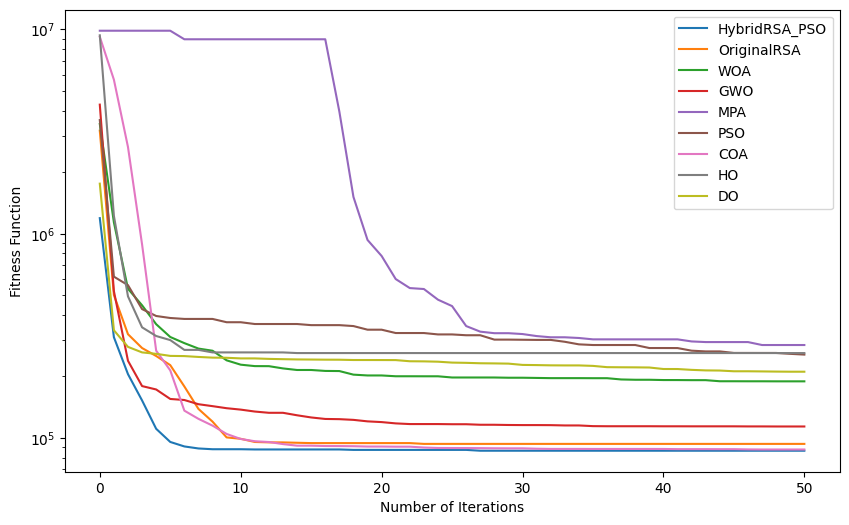

In [13]:
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    # 1. Configure experiments
    algorithms = [HybridRSA_PSO,OriginalRSA,WOA,GWO,MPA,PSO,COA,HO,DO]  # Add competitors here
    benchmarks = [CEC2014_F3(dim=30)] # Add benchmark functions here as an array(Algorithms will be evaluated on all benchmarks in the array)

    # 2. Run all experiments
    results = run_experiment(algorithms, benchmarks)

    # 3. Generate convergence plot
    plt.figure(figsize=(10, 6))
    for algo, data in results['CEC2014_F3'].items(): # Mention the function for generating the convergence graph(single graph will be  generated at a time)
        median_history = np.median([h for h in data['histories']], axis=0)
        plt.plot(median_history, label=algo)

    plt.xlabel('Number of Iterations')
    plt.ylabel('Fitness Function')
    plt.yscale('log')
    plt.legend()
    plt.savefig('convergence.png')
    plt.show()
